In [1]:
import cv2
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import geopy.distance as distance
import geopandas as gpd
from shapely.geometry import Point

import rioxarray
from IPython.display import Image
from PIL import Image as PILImage

In [2]:
# Establish a connection to the STAC API
import planetary_computer as pc
from pystac_client import Client

sat_image_catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)

In [3]:
# get path to the data folder
DATA_DIR = Path.cwd().parent.resolve() / "data"
assert DATA_DIR.exists()

In [4]:
# read .csv files

train_labels = pd.read_csv(DATA_DIR / "train_labels.csv")
#train_labels.head()

submission_format = pd.read_csv(DATA_DIR / "submission_format.csv", index_col=0)
#submission_format.head()

metadata = pd.read_csv(DATA_DIR / "metadata.csv")
#metadata.head()

In [5]:
#example_row = metadata[metadata.uid == "garm"].iloc[0]
#example_row = metadata[metadata.uid == "fund"].iloc[0]
example_row = metadata[metadata.uid == "aafl"].iloc[0] # high severity (class 4)
example_row

uid                aafl
latitude      39.474744
longitude    -86.898353
date         2021-08-23
split             train
Name: 5, dtype: object

In [6]:
# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=50000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]


bbox = get_bounding_box(example_row.latitude, example_row.longitude, meter_buffer=500)
bbox

[-86.9041639439351, 39.47024049004548, -86.8925420560649, 39.479247506456446]

In [7]:
# get our date range to search, and format correctly for query
def get_date_range(date, time_buffer_days=15):
    """Get a date range to search for in the planetary computer based
    on a sample's date. The time range will include the sample date
    and time_buffer_days days prior

    Returns a string"""
    datetime_format = "%Y-%m-%dT"
    range_start = pd.to_datetime(date) - timedelta(days=time_buffer_days)
    date_range = f"{range_start.strftime(datetime_format)}/{pd.to_datetime(date).strftime(datetime_format)}"

    return date_range


date_range = get_date_range(example_row.date, time_buffer_days=15)
date_range

'2021-08-08T/2021-08-23T'

In [8]:
# search the planetary computer sentinel-l2a and landsat level-2 collections
search = sat_image_catalog.search(
    collections=["sentinel-2-l2a", "landsat-c2-l2"], bbox=bbox, datetime=date_range
)

# see how many items were returned
items = [item for item in search.get_all_items()]
len(items)

20

In [9]:
search.get_all_items()

ID: S2B_MSIL2A_20210823T163839_R126_T16SEJ_20210824T042354
"Bounding Box: [-87.000244, 38.85379697378687, -86.68799, 39.7502679270046]"
Datetime: 2021-08-23 16:38:39.024000+00:00
datetime: 2021-08-23T16:38:39.024000Z
platform: Sentinel-2B
proj:epsg: 32616
instruments: ['msi']
s2:mgrs_tile: 16SEJ
constellation: Sentinel 2
s2:granule_id: S2B_OPER_MSI_L2A_TL_ESRI_20210824T042355_A023318_T16SEJ_N03.00
eo:cloud_cover: 12.223859


In [10]:
# get details of all of the items returned
item_details = pd.DataFrame(
    [
        {
            "datetime": item.datetime.strftime("%Y-%m-%d"),
            "platform": item.properties["platform"],
            "min_long": item.bbox[0],
            "max_long": item.bbox[2],
            "min_lat": item.bbox[1],
            "max_lat": item.bbox[3],
            "bbox": item.bbox,
            "item_obj": item,
        }
        for item in items
    ]
)

# check which rows actually contain the sample location
item_details["contains_sample_point"] = (
    (item_details.min_lat < example_row.latitude)
    & (item_details.max_lat > example_row.latitude)
    & (item_details.min_long < example_row.longitude)
    & (item_details.max_long > example_row.longitude)
)

print(
    f"Filtering from {len(item_details)} returned to {item_details.contains_sample_point.sum()} items that contain the sample location"
)

item_details = item_details[item_details["contains_sample_point"]]
item_details[["datetime", "platform", "contains_sample_point", "bbox"]].sort_values(
    by="datetime"
)

Filtering from 20 returned to 20 items that contain the sample location


,datetime,platform,contains_sample_point,bbox
19,2021-08-08,Sentinel-2A,True,"[-88.16763, 38.755193805393134, -86.88608, 39...."
18,2021-08-08,Sentinel-2A,True,"[-87.000244, 38.858758643178106, -86.68982, 39..."
17,2021-08-10,landsat-7,True,"[-88.87018408, 39.36886494, -85.91228081, 41.3..."
16,2021-08-10,landsat-7,True,"[-89.28654066, 37.93723492, -86.38796461, 39.9..."
15,2021-08-10,Sentinel-2B,True,"[-88.01459, 38.75580164280905, -86.88608, 39.7..."
14,2021-08-10,Sentinel-2B,True,"[-87.000244, 38.754036048213806, -85.71872, 39..."
13,2021-08-11,landsat-8,True,"[-87.4661504, 37.82749488, -84.76905448, 39.95..."
12,2021-08-13,Sentinel-2B,True,"[-88.16763, 38.755193805393134, -86.88608, 39...."
11,2021-08-13,Sentinel-2B,True,"[-87.000244, 38.86781294508336, -86.692474, 39..."
10,2021-08-15,Sentinel-2A,True,"[-88.01102, 38.755817531952644, -86.88608, 39...."


In [11]:
# 1 - filter to sentinel
item_details[item_details.platform.str.contains("Sentinel")]

,datetime,platform,min_long,max_long,min_lat,max_lat,bbox,item_obj,contains_sample_point
0,2021-08-23,Sentinel-2B,-87.000244,-86.687990,38.853797,39.750268,"[-87.000244, 38.85379697378687, -86.68799, 39....",<Item id=S2B_MSIL2A_20210823T163839_R126_T16SE...,True
1,2021-08-23,Sentinel-2B,-88.167630,-86.886080,38.755194,39.750212,"[-88.16763, 38.755193805393134, -86.88608, 39....",<Item id=S2B_MSIL2A_20210823T163839_R126_T16SD...,True
2,2021-08-20,Sentinel-2B,-87.000244,-85.718720,38.754036,39.750268,"[-87.000244, 38.754036048213806, -85.71872, 39...",<Item id=S2B_MSIL2A_20210820T162829_R083_T16SE...,True
3,2021-08-20,Sentinel-2B,-88.011080,-86.886080,38.755817,39.750212,"[-88.01108, 38.75581713585763, -86.88608, 39.7...",<Item id=S2B_MSIL2A_20210820T162829_R083_T16SD...,True
5,2021-08-18,Sentinel-2A,-87.000244,-86.690890,38.864400,39.750268,"[-87.000244, 38.86439992695277, -86.69089, 39....",<Item id=S2A_MSIL2A_20210818T163901_R126_T16SE...,True
6,2021-08-18,Sentinel-2A,-88.167630,-86.886080,38.755194,39.750212,"[-88.16763, 38.755193805393134, -86.88608, 39....",<Item id=S2A_MSIL2A_20210818T163901_R126_T16SD...,True
9,2021-08-15,Sentinel-2A,-87.000244,-85.718720,38.754036,39.750268,"[-87.000244, 38.754036048213806, -85.71872, 39...",<Item id=S2A_MSIL2A_20210815T162901_R083_T16SE...,True
10,2021-08-15,Sentinel-2A,-88.011020,-86.886080,38.755818,39.750212,"[-88.01102, 38.755817531952644, -86.88608, 39....",<Item id=S2A_MSIL2A_20210815T162901_R083_T16SD...,True
11,2021-08-13,Sentinel-2B,-87.000244,-86.692474,38.867813,39.750268,"[-87.000244, 38.86781294508336, -86.692474, 39...",<Item id=S2B_MSIL2A_20210813T163839_R126_T16SE...,True
12,2021-08-13,Sentinel-2B,-88.167630,-86.886080,38.755194,39.750212,"[-88.16763, 38.755193805393134, -86.88608, 39....",<Item id=S2B_MSIL2A_20210813T163839_R126_T16SD...,True


In [12]:
# 2 - take closest by date
best_item = (
    item_details[item_details.platform.str.contains("Sentinel")]
    .sort_values(by="datetime", ascending=False)
    .iloc[0]
)
best_item

datetime                                                        2021-08-23
platform                                                       Sentinel-2B
min_long                                                        -87.000244
max_long                                                         -86.68799
min_lat                                                          38.853797
max_lat                                                          39.750268
bbox                     [-87.000244, 38.85379697378687, -86.68799, 39....
item_obj                 <Item id=S2B_MSIL2A_20210823T163839_R126_T16SE...
contains_sample_point                                                 True
Name: 0, dtype: object

In [13]:
item = best_item.item_obj

# What assets are available?
for asset_key, asset in item.assets.items():
    print(f"{asset_key:<25} - {asset.title}")

AOT                       - Aerosol optical thickness (AOT)
B01                       - Band 1 - Coastal aerosol - 60m
B02                       - Band 2 - Blue - 10m
B03                       - Band 3 - Green - 10m
B04                       - Band 4 - Red - 10m
B05                       - Band 5 - Vegetation red edge 1 - 20m
B06                       - Band 6 - Vegetation red edge 2 - 20m
B07                       - Band 7 - Vegetation red edge 3 - 20m
B08                       - Band 8 - NIR - 10m
B09                       - Band 9 - Water vapor - 60m
B11                       - Band 11 - SWIR (1.6) - 20m
B12                       - Band 12 - SWIR (2.2) - 20m
B8A                       - Band 8A - Vegetation red edge 4 - 20m
SCL                       - Scene classfication map (SCL)
WVP                       - Water vapour (WVP)
visual                    - True color image
preview                   - Thumbnail
safe-manifest             - SAFE manifest
granule-metadata          - Granul

## Testing with different bands

[Sentinel 2 Bands and Combinations](https://gisgeography.com/sentinel-2-bands-combinations/)

In [14]:
bands_descr = {
    'AOT': 'Aerosol optical thickness (AOT)',
    'B01': 'Coastal aerosol - 60m',
    'B02': 'Blue - 10m',
    'B03': 'Green - 10m',
    'B04': 'Red - 10m',
    'B05': 'Vegetation red edge 1 - 20m',
    'B06': 'Vegetation red edge 2 - 20m',
    'B07': 'Vegetation red edge 3 - 20m',
    'B08': 'NIR - 10m',
    'B09': 'Water vapor - 60m',
    'B11': 'Short Wave IR (1.6) - 20m',
    'B12': 'Short Wave IR (2.2) - 20m',
    'B8A': 'Vegetation red edge 4 - 20m',
    'SCL': 'Scene classfication map (SCL)',
    'WVP': 'Water vapour (WVP)',
}
bands = list(bands_descr.keys())

In [15]:
(minx, miny, maxx, maxy) = get_bounding_box(example_row.latitude, example_row.longitude, meter_buffer=500)

In [16]:
bands_iter = iter(bands)

(3, 101, 101)
(1, 51, 51)


Text(0.5, 1.0, 'B06')

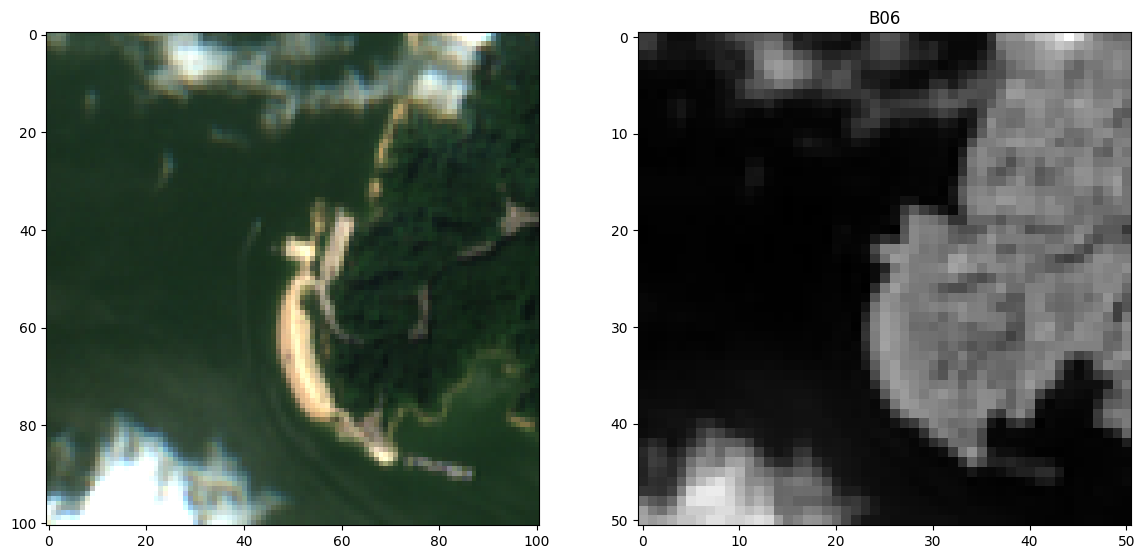

In [23]:
band = next(bands_iter)

visual_img_array = rioxarray.open_rasterio(pc.sign(item.assets['visual'].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    ).to_numpy()
new_img_array = rioxarray.open_rasterio(pc.sign(item.assets[band].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    ).to_numpy()

print(visual_img_array.shape)
print(new_img_array.shape)

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(np.transpose(visual_img_array, axes=[1, 2, 0]))
plt.subplot(122)
plt.imshow(np.transpose(new_img_array, axes=[1, 2, 0]), cmap='gray')
plt.title(band)

In [24]:
# create numpy array for each layer and collect them in dict
image_layers = dict.fromkeys(bands, np.array(0))
for band in bands:
    image_layers[band] = rioxarray.open_rasterio(pc.sign(item.assets[band].href)).rio.clip_box(
            minx=minx,
            miny=miny,
            maxx=maxx,
            maxy=maxy,
            crs="EPSG:4326",
        ).to_numpy()


In [38]:
np.array([image_layers['B02'][0], image_layers['B03'][0]]).shape

(2, 101, 101)

In [41]:
image_layers['B02'][0]

array([[ 941, 1020, 1076, ...,  378,  466,  414],
       [ 798, 1001,  992, ...,  342,  427,  446],
       [ 538,  745,  743, ...,  385,  399,  432],
       ...,
       [2510, 2234, 2054, ...,  294,  301,  284],
       [2322, 2376, 2490, ...,  287,  289,  281],
       [2066, 2326, 2598, ...,  298,  298,  289]], dtype=uint16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


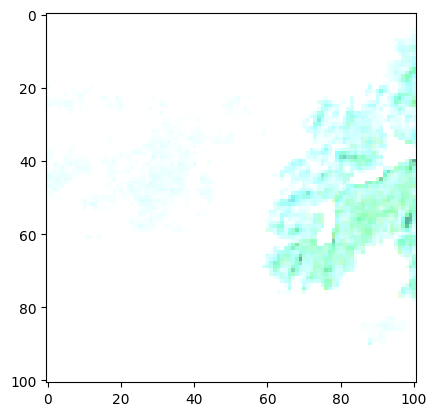

In [40]:
plt.imshow(np.transpose(np.array([image_layers['B04'][0], image_layers['B03'][0], image_layers['B02'][0]]), axes=[1, 2, 0]))

In [16]:
# see the whole image
img = Image(url=item.assets["rendered_preview"].href, width=500)

Image(url=item.assets["rendered_preview"].href, width=500)

In [17]:
def crop_sentinel_image(item, bounding_box):
    """
    Given a STAC item from Sentinel-2 and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    image = rioxarray.open_rasterio(pc.sign(item.assets["visual"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    )

    return image.to_numpy()

In [18]:
# get a smaller geographic bounding box
minx, miny, maxx, maxy = get_bounding_box(
    example_row.latitude, example_row.longitude, meter_buffer=500
)

# get the zoomed in image array
bbox = (minx, miny, maxx, maxy)
zoomed_img_array = crop_sentinel_image(item, bbox)

zoomed_img_array[0]

array([[  3,   3,   3, ..., 159, 172, 200],
       [  3,   2,   3, ..., 176, 193, 211],
       [  3,   3,   2, ..., 159, 158, 168],
       ...,
       [  3,   1,   2, ..., 103, 101, 105],
       [  2,   1,   3, ..., 113, 104, 105],
       [  2,   2,   3, ..., 114, 106, 104]], dtype=uint8)

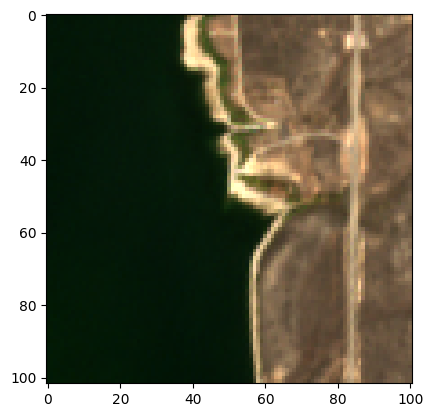

In [19]:
# we have to transpose some of the dimensions to plot
# matplotlib expects channels in a certain order
plt.imshow(np.transpose(zoomed_img_array, axes=[1, 2, 0]))

In [20]:
zoomed_img_array.shape

(3, 102, 101)

### Landsat

In [21]:
landsat_item = (
    item_details[item_details.platform.str.contains("landsat")]
    .sample(n=1, random_state=3)
    .iloc[0]
)
landsat_item

datetime                                                        2021-09-12
platform                                                         landsat-8
min_long                                                       -111.340237
max_long                                                       -108.515287
min_lat                                                          40.677025
max_lat                                                          42.817595
bbox                     [-111.34023745, 40.67702495, -108.51528663, 42...
item_obj                         <Item id=LC08_L2SP_037031_20210912_02_T1>
contains_sample_point                                                 True
Name: 6, dtype: object

In [22]:
def crop_landsat_image(item, bounding_box):
    """
    Given a STAC item from Landsat and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    image = odc.stac.stac_load(
        [pc.sign(item)], bands=["red", "green", "blue"], bbox=[minx, miny, maxx, maxy]
    ).isel(time=0)
    image_array = image[["red", "green", "blue"]].to_array().to_numpy()

    # normalize to 0 - 255 values
    image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX)

    return image_array

In [23]:
item = landsat_item.item_obj

# we'll use the same cropped area as above
landsat_image_array = crop_landsat_image(item, bbox)
landsat_image_array[0]

array([[ 98,  98,  88, ..., 168, 182, 191],
       [102,  97,  87, ..., 173, 179, 186],
       [107,  96,  87, ..., 173, 168, 168],
       ...,
       [102, 102, 101, ..., 145, 148, 149],
       [102, 102, 102, ..., 146, 148, 148],
       [102, 102, 102, ..., 147, 153, 152]], dtype=uint16)

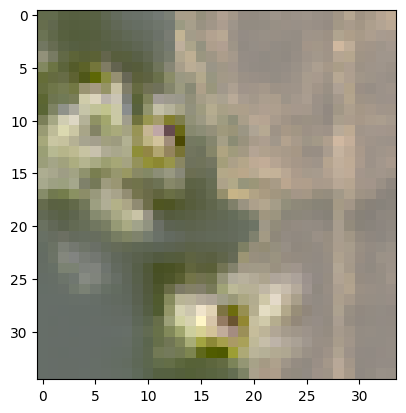

In [24]:
plt.imshow(np.transpose(landsat_image_array, axes=[1, 2, 0]))

In [25]:
# load image but don't convert to numpy or rescale
image = odc.stac.stac_load(
    [pc.sign(item)], bands=["red", "green", "blue"], bbox=bbox
).isel(time=0)
image_array = image[["red", "green", "blue"]].to_array()

# values are not scaled 0 - 255 when first returned
image_array[0]

<xarray.DataArray (y: 35, x: 34)>
array([[ 7171,  7162,  6447, ..., 12262, 13264, 13933],
       [ 7422,  7087,  6307, ..., 12606, 13059, 13587],
       [ 7832,  6972,  6332, ..., 12601, 12219, 12242],
       ...,
       [ 7425,  7410,  7396, ..., 10573, 10757, 10887],
       [ 7424,  7407,  7413, ..., 10609, 10791, 10824],
       [ 7423,  7401,  7402, ..., 10733, 11147, 11104]], dtype=uint16)
Coordinates:
  * y            (y) float64 4.648e+06 4.648e+06 ... 4.647e+06 4.647e+06
  * x            (x) float64 5.279e+05 5.279e+05 ... 5.289e+05 5.289e+05
    spatial_ref  int32 32612
    time         datetime64[ns] 2021-09-12T18:01:53.979983
    variable     <U3 'red'

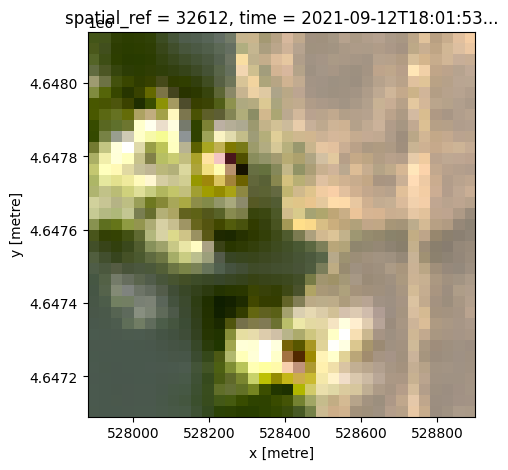

In [26]:
# image appears differently without rescaling
fig, ax = plt.subplots(figsize=(5, 5))
image_array.plot.imshow(robust=True, ax=ax)

### Feature reduction / detection

In [ ]:
# define a small area to crop around
# crop to 400 meters squared around the sampling point
minx, miny, maxx, maxy = get_bounding_box(
    example_row.latitude, example_row.longitude, meter_buffer=100
)
minx, miny, maxx, maxy

In [ ]:
bbox = (minx, miny, maxx, maxy)
feature_image_array = crop_sentinel_image(best_item.item_obj, bounding_box=bbox)

plt.imshow(np.transpose(feature_image_array, axes=[1, 2, 0]))

In [ ]:
type(feature_image_array), feature_image_array.shape

In [ ]:
# take the average over the second and third dimensions
image_color_averages = feature_image_array.mean(axis=(1, 2)).tolist()

# also take the median
image_color_medians = np.median(feature_image_array, axis=(1, 2)).tolist()

# concatenate the two lists
image_features = image_color_averages + image_color_medians
image_features

### same process for all the data

In [ ]:
# Refactor our process from above into functions
def select_best_item(items, date, latitude, longitude):
    """
    Select the best satellite item given a sample's date, latitude, and longitude.
    If any Sentinel-2 imagery is available, returns the closest sentinel-2 image by
    time. Otherwise, returns the closest Landsat imagery.

    Returns a tuple of (STAC item, item platform name, item date)
    """
    # get item details
    item_details = pd.DataFrame(
        [
            {
                "datetime": item.datetime.strftime("%Y-%m-%d"),
                "platform": item.properties["platform"],
                "min_long": item.bbox[0],
                "max_long": item.bbox[2],
                "min_lat": item.bbox[1],
                "max_lat": item.bbox[3],
                "item_obj": item,
            }
            for item in items
        ]
    )

    # filter to items that contain the point location, or return None if none contain the point
    item_details["contains_sample_point"] = (
        (item_details.min_lat < latitude)
        & (item_details.max_lat > latitude)
        & (item_details.min_long < longitude)
        & (item_details.max_long > longitude)
    )
    item_details = item_details[item_details["contains_sample_point"] == True]
    if len(item_details) == 0:
        return (np.nan, np.nan, np.nan)

    # add time difference between each item and the sample
    item_details["time_diff"] = pd.to_datetime(date) - pd.to_datetime(
        item_details["datetime"]
    )

    # if we have sentinel-2, filter to sentinel-2 images only
    item_details["sentinel"] = item_details.platform.str.lower().str.contains(
        "sentinel"
    )
    if item_details["sentinel"].any():
        item_details = item_details[item_details["sentinel"] == True]

    # return the closest imagery by time
    best_item = item_details.sort_values(by="time_diff", ascending=True).iloc[0]

    return (best_item["item_obj"], best_item["platform"], best_item["datetime"])


def image_to_features(image_array):
    """
    Convert an image array of the form (color band, height, width) to a
    1-dimensional list of features. Returns a list where the first three
    values are the averages of each color band, and the second three
    values are the medians of each color band.
    """
    averages = image_array.mean(axis=(1, 2)).tolist()
    medians = np.median(image_array, axis=(1, 2)).tolist()

    return averages + medians

In [ ]:
BENCHMARK_DATA_DIR = DATA_DIR / "benchmark"

# save image arrays in case we want to generate more features
IMAGE_ARRAY_DIR = BENCHMARK_DATA_DIR / "image_arrays"
IMAGE_ARRAY_DIR.mkdir(exist_ok=True, parents=True)

In [ ]:
# take a random subset of the training data for the benchmark
train_subset = metadata[metadata["split"] == "train"].sample(n=2500, random_state=2)

# combine train subset with all test data
metadata_subset = pd.concat([train_subset, metadata[metadata["split"] == "test"]])
metadata_subset.split.value_counts(dropna=False)

In [ ]:
# this cell takes a LONG time because it iterates over all data!

# save outputs in dictionaries
selected_items = {}
features_dict = {}
errored_ids = []


for row in tqdm(metadata_subset.itertuples(), total=len(metadata_subset)):
    pass
    # check if we've already saved the selected image array
    image_array_pth = IMAGE_ARRAY_DIR / f"{row.uid}.npy"

    if image_array_pth.exists():
        with open(image_array_pth, "rb") as f:
            image_array = np.load(f)

        # convert image to 1-dimensional features
        image_features = image_to_features(image_array)
        features_dict[row.uid] = image_features

    # search and load the image array if not
    else:
        try:
            ## QUERY STAC API
            # get query ranges for location and date
            search_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=50000
            )
            date_range = get_date_range(row.date, time_buffer_days=15)

            # search the planetary computer
            search = sat_image_catalog.search(
                collections=["sentinel-2-l2a", "landsat-c2-l2"],
                bbox=search_bbox,
                datetime=date_range,
            )
            items = [item for item in search.get_all_items()]

            ## GET BEST IMAGE
            if len(items) == 0:
                pass
            else:
                best_item, item_platform, item_date = select_best_item(
                    items, row.date, row.latitude, row.longitude
                )
                # add to dictionary tracking best items
                selected_items[row.uid] = {
                    "item_object": best_item,
                    "item_platform": item_platform,
                    "item_date": item_date,
                }

            ## CONVERT TO FEATURES
            # get small bbox just for features
            feature_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=100
            )

            # crop the image
            if "sentinel" in item_platform.lower():
                image_array = crop_sentinel_image(best_item, feature_bbox)
            else:
                image_array = crop_landsat_image(best_item, feature_bbox)

            # save image array so we don't have to rerun
            with open(image_array_pth, "wb") as f:
                np.save(f, image_array)

            # convert image to 1-dimensional features
            image_features = image_to_features(image_array)
            features_dict[row.uid] = image_features

        # keep track of any that ran into errors without interrupting the process
        except:
            errored_ids.append(row.uid)

In [ ]:
# see how many ran into errors
print(f"Could not pull satellite imagery for {len(errored_ids)} samples")

In [ ]:
# bring features into a dataframe
image_features = pd.DataFrame(features_dict).T
image_features.columns = [
    "red_average",
    "green_average",
    "blue_average",
    "red_median",
    "green_median",
    "blue_median",
]
image_features.head()

In [ ]:
# save out our features!
image_features.to_csv(BENCHMARK_DATA_DIR / "image_features.csv", index=True)

### (baseline) Model

In [ ]:
# bring together train labels and features into one dataframe
# this ensures the features array and labels array will be in same order
train_data = train_labels.merge(
    image_features, how="inner", left_on="uid", right_index=True, validate="1:1"
)

# split into train and validation
rng = np.random.RandomState(30)
train_data["split"] = rng.choice(
    ["train", "validation"], size=len(train_data), replace=True, p=[0.67, 0.33]
)

train_data.head()

In [ ]:
# separate features and labels, and train and validation
feature_cols = [
    "red_average",
    "green_average",
    "blue_average",
    "red_median",
    "green_median",
    "blue_median",
]
target_col = "severity"

val_set_mask = train_data.split == "validation"
X_train = train_data.loc[~val_set_mask, feature_cols].values
y_train = train_data.loc[~val_set_mask, target_col]
X_val = train_data.loc[val_set_mask, feature_cols].values
y_val = train_data.loc[val_set_mask, target_col]

# flatten label data into 1-d arrays
y_train = y_train.values.flatten()
y_val = y_val.values.flatten()

X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [ ]:
# see an example of what the data looks like
print("X_train[0]:", X_train[0])
print("y_train[:10]:", y_train[:10])

In [ ]:
# save out features
x_train_pth = BENCHMARK_DATA_DIR / "x_train.npy"
x_train_pth.parent.mkdir(exist_ok=True, parents=True)

with open(x_train_pth, "wb") as f:
    np.save(f, X_train)

# save out labels
y_train_pth = BENCHMARK_DATA_DIR / "y_train.npy"

with open(y_train_pth, "wb") as f:
    np.save(f, y_train)

In [ ]:
%%writefile train_gbm_model.py
import lightgbm as lgb

import joblib
import numpy as np
from pathlib import Path
from loguru import logger
import typer

DATA_DIR = Path.cwd().parent / "data/benchmark"


def main(
    features_path=DATA_DIR / "x_train.npy",
    labels_path=DATA_DIR / "y_train.npy",
    model_save_path=DATA_DIR / "lgb_classifier.txt",
):
    """
    Train a LightGBM model based on training features in features_path and
    training labels in labels_path. Save our the trained model to model_save_path
    """

    # load saved features and labels
    with open(features_path, "rb") as f:
        X_train = np.load(f)
    with open(labels_path, "rb") as f:
        y_train = np.load(f)

    logger.info(f"Loaded training features of shape {X_train.shape} from {features_path}")
    logger.info(f"Loading training labels of shape {y_train.shape} from {labels_path}")

    # instantiate tree model
    model = lgb.LGBMClassifier(random_state=10)

    # fit model
    logger.info("Fitting LGBM model")
    model.fit(X_train, y_train)
    print(model)

    # save out model weights
    joblib.dump(model, str(model_save_path))
    logger.success(f"Model weights saved to {model_save_path}")


if __name__ == "__main__":
    typer.run(main)

In [ ]:
!python train_gbm_model.py

In [ ]:
# save out validation features
x_val_pth = BENCHMARK_DATA_DIR / "x_val.npy"
x_val_pth.parent.mkdir(exist_ok=True, parents=True)

with open(x_val_pth, "wb") as f:
    np.save(f, X_val)

# save out validation labels
y_val_pth = BENCHMARK_DATA_DIR / "y_val.npy"

with open(y_val_pth, "wb") as f:
    np.save(f, y_val)

In [ ]:
%%writefile predict_gbm_model.py
import lightgbm as lgb

import joblib
from loguru import logger
import numpy as np
from pathlib import Path
import typer

DATA_DIR = Path.cwd().parent / "data/benchmark"


def main(
    model_weights_path=DATA_DIR / "lgb_classifier.txt",
    features_path=DATA_DIR / "x_val.npy",
    preds_save_path=DATA_DIR / "val_preds.npy",
):
    """
    Generate predictions with a LightGBM model using weights saved at model_weights_path
    and features saved at features_path. Save out predictions to preds_save_path.
    """
    # load model weights
    lgb_model = joblib.load(model_weights_path)
    logger.info(f"Loaded model {lgb_model} from {model_weights_path}")

    # load the features
    with open(features_path, "rb") as f:
        X_val = np.load(f)
    logger.info(f"Loaded features of shape {X_val.shape} from {features_path}")

    # generate predictions
    preds = lgb_model.predict(X_val)

    # save out predictions
    with open(preds_save_path, "wb") as f:
        np.save(f, preds)
    logger.success(f"Predictions saved to {preds_save_path}")


if __name__ == "__main__":
    typer.run(main)

In [ ]:
!python predict_gbm_model.py

In [ ]:
preds_pth = BENCHMARK_DATA_DIR / "val_preds.npy"
with open(preds_pth, "rb") as f:
    val_preds = np.load(f)

In [ ]:
val_preds[:10]

In [ ]:
pd.Series(val_preds).value_counts().sort_index()

In [ ]:
# get the validation part of the training data
val_set = train_data[train_data.split == "validation"][
    ["uid", "region", "severity"]
].copy()
val_set["pred"] = val_preds

val_set.head()

In [ ]:
region_scores = []
for region in val_set.region.unique():
    sub = val_set[val_set.region == region]
    region_rmse = mean_squared_error(sub.severity, sub.pred, squared=False)
    print(f"RMSE for {region} (n={len(sub)}): {round(region_rmse, 4)}")
    region_scores.append(region_rmse)

overall_rmse = np.mean(region_scores)
print(f"Final score: {overall_rmse}")

In [ ]:
# what's our RMSE across all validation data points?
mean_squared_error(y_val, val_preds, squared=False)

In [ ]:
# how many times did each severity level show up in our predictions vs. the actual values?
val_results = pd.DataFrame({"pred": val_preds, "actual": y_val})

pd.concat(
    [
        val_results.pred.value_counts().sort_index().rename("predicted"),
        val_results.actual.value_counts().sort_index().rename("actual"),
    ],
    axis=1,
).rename_axis("severity_level_count")

### Submission (.csv)

In [ ]:
# get the image features for the test set
test_features = submission_format.join(image_features, how="left")#, validate="1:1")

# make sure our features are in the same order as the submission format
assert (test_features.index == submission_format.index).all()

test_features.head()

In [ ]:
test_features.isna().sum()

In [ ]:
# fill in missing values
for avg_col in ["red_average", "green_average", "blue_average"]:
    test_features[avg_col] = test_features[avg_col].fillna(
        test_features[avg_col].mean()
    )
for median_col in ["red_median", "green_median", "blue_median"]:
    test_features[median_col] = test_features[median_col].fillna(
        test_features[median_col].median()
    )

In [ ]:
# select feature columns
feature_cols = [
    "red_average",
    "green_average",
    "blue_average",
    "red_median",
    "green_median",
    "blue_median",
]

X_test = test_features[feature_cols].values

print(X_test.shape)

X_test[1]

In [ ]:
# save out test features
x_test_pth = BENCHMARK_DATA_DIR / "x_test.npy"
with open(x_test_pth, "wb") as f:
    np.save(f, X_test)

In [ ]:
test_preds_pth = BENCHMARK_DATA_DIR / "test_preds.npy"

In [ ]:
!python predict_gbm_model.py --features-path {x_test_pth} --preds-save-path {test_preds_pth}

In [ ]:
# load our predictions
with open(test_preds_pth, "rb") as f:
    test_preds = np.load(f)

In [ ]:
submission = submission_format.copy()
submission["severity"] = test_preds

submission.head()

In [ ]:
# save out our formatted submission
submission_save_path = BENCHMARK_DATA_DIR / "submission.csv"
submission.to_csv(submission_save_path, index=True)

In [ ]:
# make sure our saved csv looks correct
!cat {submission_save_path} | head -5